1. This notebook implements SARSA with the UCB and Softmax as action select strategy.
2. All other things are kept same as in decayEps notebook.
3. The experimentation for Softmax and UCB is done separately.

In [339]:
!pip3 install -e gym-env
# !pip3 install pygame

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/kabhay/Documents/courses/RL_project/Foraging_in_replenishing_patches/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 0.0.1
    Uninstalling gym-env-0.0.1:
      Successfully uninstalled gym-env-0.0.1
  Running setup.py develop for gym-env
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [340]:
import gym
from gym import error, spaces, utils
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

In [341]:
from blocks import EnvClass

In [342]:
def playEnv(env,policy):
    
    env.reset()
    
    s = env.present_state
    
    done = False

    a = int(policy[s][0])

    cur_reward = 0

    while not done:

        out = env.step(a)

        (s_prime,t),r,done,_ = out
        
        cur_reward += r
        a = int(policy[int(s_prime)][int(r)])
        
    return cur_reward

In [343]:
def decayEpsilon(eps,noEpisodes,decayUntil,min_eps=0.01,decayType='linear'):
    
    epsilons = np.empty(noEpisodes)
    
    epsilons.fill(min_eps)
    
    if decayType == 'linear':
        
        rate = (eps - min_eps) / decayUntil
        
        for i in range(decayUntil+1):
            epsilons[i] = eps - i*rate
    
    else :
        
        rate = (eps/min_eps)** (1/decayUntil)
        
        for i in range(decayUntil+1):
            epsilons[i] = eps * (rate**i)

    
    return epsilons

In [344]:
def decayAlpha(alpha, noEpisodes,maxSteps,final_alpha = 0.01,decayType='linear'):
    
    alphas = [float(final_alpha)] * noEpisodes
    
    if decayType == 'linear':
        
        rate = (alpha - final_alpha) / maxSteps
        
        for i in range(maxSteps+1):
            alphas[i] = alpha - i*rate
    
    else :
        
        rate = (final_alpha/alpha)** (1/maxSteps)
        
        for i in range(maxSteps+1):
            alphas[i] = alpha * (rate**i)
    
    return alphas

In [345]:
def actionSelect(s,r,Q,eps):
    
    q = Q[s][r]
    
    if np.random.rand() > eps:
        a = np.random.choice(np.where(q == q.max())[0])
    else :
        a = np.random.randint(0,len(q))
    
    return a

In [346]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [347]:
from tqdm import tqdm

In [348]:
def UCB_actionSelect(curr_state, curr_r, curr_q, c, stepCounter, actionCounter):
    if(np.any(actionCounter[curr_state][curr_r] == 0)):
        return(np.where(actionCounter[curr_state][curr_r] == 0)[0][0])
    else:
        U = c*np.sqrt(np.log(stepCounter[curr_state][curr_r])/actionCounter[curr_state][curr_r])
        return(np.argmax(U+curr_q[curr_state][curr_r]))

In [349]:
#reference : lecture slides

def SARSA_UCB(env,c,gamma,alpha,eps,noEpisodes,epsilons = [0]) :
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    Q = np.zeros((n_states,201,n_actions))
    actionCounter = np.zeros((n_states,201,n_actions))
    
    stepCounter = np.zeros((n_states,201))
    
    if epsilons[0] == 0:
        epsilons = decayEpsilon(eps,noEpisodes,noEpisodes,min_eps = 0.1, decayType = 'linear')
        
    alphas = decayAlpha(alpha,noEpisodes,int(3*noEpisodes/4) ,final_alpha = 0.02 ,decayType = 'linear')
    
    rewards = np.zeros((noEpisodes)) 
    greedy_rewards = np.zeros((noEpisodes))
    
    for e in tqdm(range(noEpisodes)):
        
        cur_alpha = alphas[e]
        cur_eps = epsilons[e]
        env.reset()
        s = env.present_state
        done = False
        
        a = UCB_actionSelect(s,0,Q,c,stepCounter,actionCounter)
        
        eps_reward = 0

        r = 0
        
        
        while not done:

            out = env.step(a)
            
            (s_prime,t),r_new,done,_ = out
            
                
            eps_reward += r_new
            
            stepCounter[s][r] += 1
            actionCounter[s][r][a] += 1
            
            a_prime = UCB_actionSelect(s_prime,int(r_new),Q,c,stepCounter,actionCounter)
            
            td_target = r_new
            
            if not done :
                td_target += gamma * Q[s_prime][int(r_new)][a_prime]
                
            td_error = td_target - Q[s][int(r)][a]
                
            Q[s][int(r)][a] = Q[s][int(r)][a] + cur_alpha * td_error
            
            s = s_prime
            
            a = a_prime
            
            r = r_new
            
        rewards[e] = eps_reward
        greedy_rewards[e] = playEnv(env,GreedyPolicy(Q))
    
    pi = GreedyPolicy(Q)
    
    return Q,pi,rewards,greedy_rewards
    

In [350]:
envs = EnvClass()

## UCB EXPERIMENTATION

In [1]:
# change this variable
block = 3

In [377]:
env_b1 = envs.getBlock(block)
num_seeds = 5

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.4
eps = 1
noEpisodes = 1000
c = 15

Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
ucb_rewards_ = np.zeros((num_seeds,noEpisodes))
ucb_greedy_ = np.zeros((num_seeds,noEpisodes))

In [378]:
for i in range(1,num_seeds):    
    np.random.seed(4*i)
    epsilons = np.ones((noEpisodes))
    epsilons = decayEpsilon(eps,noEpisodes,19*noEpisodes//20, min_eps = 0.01, decayType = 'linear')
    Q_[i],pi1,ucb_rewards_[i],ucb_greedy_[i] = SARSA_UCB(env_b1,c,gamma,alpha,eps,noEpisodes,epsilons)

100%|██████████| 1000/1000 [00:36<00:00, 27.36it/s]


In [379]:
ucb_avg_rewards = np.mean(ucb_rewards_[1:],axis = 0)

In [380]:
ucb_avg_greedy = np.mean(ucb_greedy_[1:],axis = 0)

In [381]:
Q_avg = np.mean(Q_[1:],axis = 0)

In [382]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [383]:
ucb_pi_ = GreedyPolicy(Q_avg)

In [384]:
playEnv(env_b1,ucb_pi_)

24363

In [385]:
for i in range(num_seeds):
    pi = GreedyPolicy(Q_[i])
    print(playEnv(env_b1,pi))

517
24363
24363
24363
24363


Text(0.5, 1.0, 'SARSA reward for block 1')

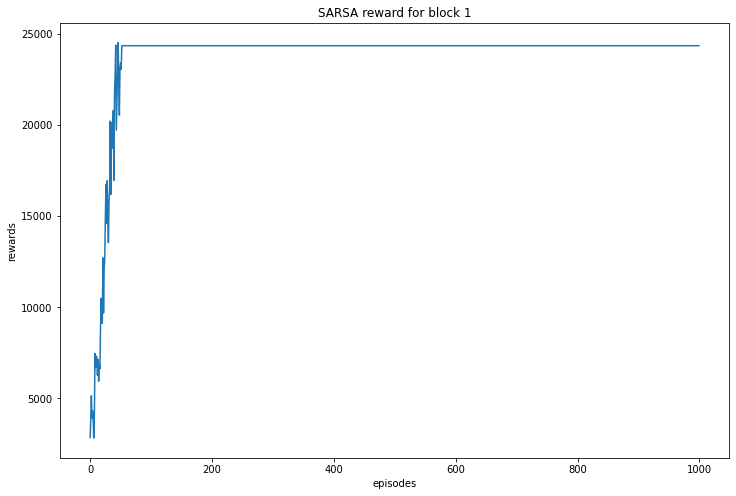

In [386]:
plt.figure(figsize=(12,8))
plt.plot(ucb_avg_rewards)
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 1")

Text(0.5, 1.0, 'SARSA reward for block 1')

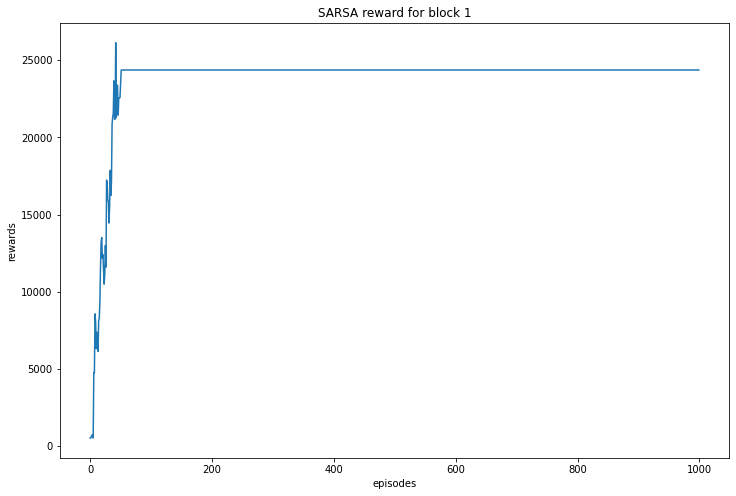

In [387]:
plt.figure(figsize=(12,8))
plt.plot(ucb_avg_greedy)
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 1")

In [388]:
np.savez('./policies/sarsa/sarsa_learning_c_15_gamma_04_B'+str(block)+'_ucb_reward.npz', ucb_rewards_)
np.savez('./policies/sarsa/sarsa_learning_c_15_gamma_04_B'+str(block)+'_ucb_greedy.npz', ucb_greedy_)
np.savez('./policies/sarsa/sarsa_learning_c_15_gamma_04_B'+str(block)+'_ucb_policy.npz', pi_)

### SOFTMAX

In [389]:
def softmax_actionSelect(curr_state,curr_r,Q,tau,e):
    
    probs = np.exp(Q[curr_state][curr_r]/tau)/np.sum(np.exp(Q[curr_state][curr_r]/tau))
#     print(tau,probs)
    if np.isnan(probs).any():
        print(Q[curr_state][curr_r])
    a = np.random.choice(8,p=probs)
    return a

In [390]:
#reference : lecture slides

def Softmax_SARSA(env,taus,gamma,alpha,noEpisodes,epsilons = [0]) :
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    Q = np.zeros((n_states,201,n_actions))
    
    if epsilons[0] == 0:
        epsilons = decayEpsilon(1,noEpisodes,noEpisodes,min_eps = 0.1, decayType = 'linear')
        
    alphas = decayAlpha(alpha,noEpisodes,int(3*noEpisodes/4) ,final_alpha = 0.02 ,decayType = 'linear')
    
    rewards = np.zeros((noEpisodes)) 
    greedy_rewards = np.zeros((noEpisodes))

    for e in tqdm(range(noEpisodes)):
        
        cur_alpha = alphas[e]
        env.reset()
        s = env.present_state
        done = False
        
        tau = taus[e]
        
        a = softmax_actionSelect(s,0,Q,tau,e)
        
        eps_reward = 0

        r = 0
        
        while not done:

            out = env.step(a)
            
            (s_prime,t),r_new,done,_ = out
            
                
            eps_reward += r_new
            
            
            a_prime = softmax_actionSelect(s_prime,int(r_new),Q,tau,e)
            
            td_target = r_new
            
            if not done :
                td_target += gamma * Q[s_prime][int(r_new)][a_prime]
                
            td_error = td_target - Q[s][int(r)][a]
                
            Q[s][int(r)][a] = Q[s][int(r)][a] + cur_alpha * td_error
            
            s = s_prime
            
            a = a_prime
            
            r = r_new
            
        rewards[e] = eps_reward
        greedy_rewards[e] = playEnv(env,GreedyPolicy(Q))
    
    pi = GreedyPolicy(Q)
    
    return Q,pi,rewards,greedy_rewards
    

## SOFTMAX EXPERIMENTATION

In [ ]:
block = 3

In [479]:
env_b1 = envs.getBlock(block)
num_seeds = 5

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.4
noEpisodes = 1000
tau_i = 1000
tau_f = 10
lin_r = (tau_f - tau_i) / (noEpisodes-1)
exp_r = (tau_f/tau_i)**(1/(noEpisodes-1))
taus = [ tau_i*(exp_r**i) for i in range(noEpisodes)]
# taus = [ tau_i+i*lin_r  for i in range(noEpisodes)]


Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
sof_rewards_ = np.zeros((num_seeds,noEpisodes))
sof_greedy_ = np.zeros((num_seeds,noEpisodes))

In [480]:
for i in range(1,num_seeds):    
    np.random.seed(4*(i+1))
    epsilons = np.ones((noEpisodes))
    epsilons = decayEpsilon(eps,noEpisodes,19*noEpisodes//20, min_eps = 0.01, decayType = 'linear')
    Q_[i],pi1,sof_rewards_[i],sof_greedy_[i] = Softmax_SARSA(env_b1,taus,gamma,alpha,noEpisodes,epsilons)

100%|██████████| 1000/1000 [00:31<00:00, 32.21it/s]


In [481]:
sof_avg_rewards = np.mean(sof_rewards_[1:],axis = 0)

In [482]:
sof_avg_greedy = np.mean(sof_greedy_[1:],axis = 0)

In [483]:
Q_avg = np.mean(Q_[1:4],axis = 0)

In [484]:
sof_pi_ = GreedyPolicy(Q_avg)

In [485]:
playEnv(env_b1,sof_pi_)

24709

In [486]:
for i in range(num_seeds):
    pi = GreedyPolicy(Q_[i])
    print(playEnv(env_b1,pi))

517
24559
25065
23505
23709


Text(0.5, 1.0, 'SARSA reward for block 1')

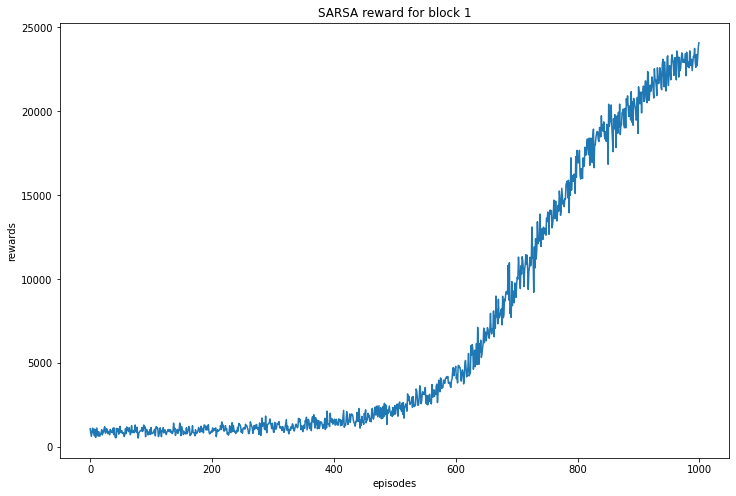

In [487]:
plt.figure(figsize=(12,8))
plt.plot(sof_avg_rewards)
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 1")

Text(0.5, 1.0, 'SARSA reward for block 1')

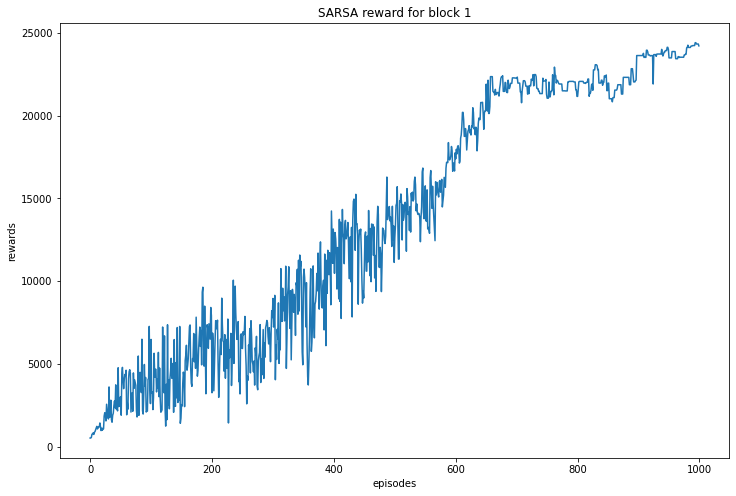

In [488]:
plt.figure(figsize=(12,8))
plt.plot(sof_avg_greedy)
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 1")

In [489]:
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B'+str(block)+'_sof_reward.npz', sof_rewards_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B'+str(block)+'_sof_greedy.npz', sof_greedy_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B'+str(block)+'_sof_policy.npz', sof_pi_)